# Basic Video Processing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import matplotlib.animation as animation
from IPython.display import HTML

## Code for Non-parametric Segmentation from previous activity

In [9]:
def RGI(image):
    R = np.float_(image[:,:,0])
    G = np.float_(image[:,:,1])
    B = np.float_(image[:,:,2])
    
    I = np.float_(R+G+B)
    I[I==0] = 100000

    r = R/I
    g = G/I
    b = B/I
    
    return np.float_(r),np.float_(g),np.float_(b)

In [10]:
def non_para(bins,p_r,p_g,im_r,im_g):
    r_int = np.round(p_r*(bins-1))
    g_int = np.round(p_g*(bins-1))
    
    R_int = np.round(im_r*(bins-1)+1)
    G_int = np.round(im_g*(bins-1)+1)
    
    return r_int,g_int,R_int,G_int

In [11]:
def segmenting(img,limit,whole):
    x,y = np.where(img<limit)
    segment = np.copy(whole)
    segment[x,y,:] = [255,255,255]
    
    plt.figure(figsize=(18,16))
    plt.subplot(131)
    plt.imshow(img,cmap='gray'),plt.xticks([]),plt.yticks([])

    plt.subplot(132)
    plt.imshow(whole),plt.xticks([]),plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(segment),plt.xticks([]),plt.yticks([])
#     plt.savefig('nonpara.png',dpi=300,bbox_inches='tight')
    plt.show()

### Perform Nonparametric Segmentation on all frames of the video

In [1]:
def segmentation(index):
    if index < 10:
        whole = plt.imread('frames/img000'+str(index)+'.png')
    else:
        whole = plt.imread('frames/img00'+str(index)+'.png')
    patch = plt.imread('patch.png')
    
    im_r,im_g,im_b = RGI(whole)
    p_r,p_g,p_b = RGI(patch)
    
    bins = 32
    r_int,g_int,R_int,G_int = non_para(bins,p_r,p_g,im_r,im_g)
    h = np.histogram2d(r_int.flatten()/bins,g_int.flatten()/bins,bins=bins,range=[[0,1],[0,1]])[0]
    
    new_img = np.zeros((whole.shape[0],whole.shape[1]))

    for i in range(whole.shape[0]-1):
        for j in range(whole.shape[1]-1):
            new_img[i][j] += h[np.int(R_int[i][j])-1,np.int(G_int[i][j])-1]
    new_img = np.round(255*new_img/np.amax(new_img)).astype('uint8')
#     segmenting(new_img,1,whole)
    
    return new_img

## Erosion and Dilation (Morphological Operations) to Clean segmented blob

In [2]:
def clean(new_img):
    cleaning = np.copy(new_img)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
    closing = cv2.morphologyEx(cleaning, cv2.MORPH_CLOSE, kernel, iterations=3)
    
#     plt.figure(figsize=(14,10))
#     plt.imshow(closing,cmap='gray')#,plt.xticks([]),plt.yticks([])
#     plt.savefig('cleaning.png',dpi=300,bbox_inches='tight')
    
    return closing

## Setting up parameters of blob detector

In [5]:
params = cv2.SimpleBlobDetector_Params()

params.filterByColor = True
params.blobColor = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 300      

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.001

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.0001

## Find keypoints and centroid using detector

In [6]:
def blob_detection(closing):
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(closing)
    centroid = keypoints[0].pt
    
    im_with_keypoints = cv2.drawKeypoints(closing, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
    
#     plt.figure(figsize=(10,8))
#     plt.imshow(im_with_keypoints)
#     plt.scatter(centroid[0],centroid[1],c='red',s=30)
#     plt.savefig('blob_detect.png',dpi=300,bbox_inches='tight')
#     plt.show()
    return im_with_keypoints,centroid

## Master function to segment, clean, and detect the blobs in all the frames

In [7]:
def master_function(file_index):
    segmented_img = segmentation(file_index)
    cleaned_img = clean(segmented_img)
    im_with_keypoints,blob_centroid = blob_detection(cleaned_img)
    
    return im_with_keypoints,blob_centroid

## Detecting the seconds hand for 64 frames

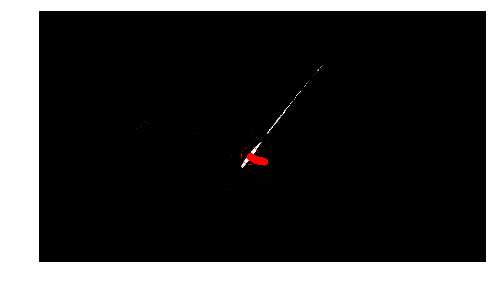

In [19]:
centroids = []
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ims = []

for i in range(64):
#     if i+1 < 10:
#         frame = plt.imread('frames/img000'+str(i+1)+'.png')
#     else:
#         frame = plt.imread('frames/img00'+str(i+1)+'.png')
        
#     im = ax.imshow(frame, animated=True)
#     ims.append([im])

    im_with_keypoints,blob_centroid = master_function(i+1)
    centroids.append(blob_centroid)
    
    im = ax.imshow(im_with_keypoints, animated=True)
    ax.axis('off')
    t = ax.scatter(blob_centroid[0],blob_centroid[1],c='red',s=30)
    ims.append([im,t])

    plt.close()

## Create Dataframe of Centroids of detected blobs per frame

In [20]:
x = [i[0] for i in centroids]
y = [i[1] for i in centroids]

In [21]:
df = pd.DataFrame(columns=['centroid x','centroid y'])
df['centroid x'] = x
df['centroid y'] = y

In [22]:
# df.to_csv('centroids.csv',index=False)

## Create animation

In [23]:
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)
HTML(ani.to_jshtml(fps=5))

In [38]:
# ani.save('clock.gif',writer='imagemagick')

MovieWriter imagemagick unavailable. Trying to use pillow instead.
